In [1]:
import scipy
import os
import numpy as np
import mne
import matplotlib.pyplot as plt

In [6]:
class Recording:
    # Data paths
    root = 'Data/'
    dir_raw = root + '/raw_data'
    
    # Parameters
    Fs = 128
    ch_type = 'eeg'
    n_channels = 32
    
    def __init__(self, data_type, sub_nr, trial_nr):
        self.data_type = data_type
        self.sub_nr = sub_nr
        self.trial_nr = trial_nr
        
        # Load data
        self.raw_data = self.load_data()
        # Create mne RawArray
        info = mne.create_info(ch_names = self.get_channels(), sfreq = self.Fs, ch_types = self.ch_type)
        self.raw_arr = mne.io.RawArray(self.data, info, first_samp=0, copy='auto', verbose=None)

        # Do initial filtering
        self.filt_arr = self.init_filter()
        
        # Set montage
        montage = mne.channels.make_standard_montage('standard_1020')
        self.filt_arr.set_montage(montage)   
    #------------------------------------------------------------------------------------------
    
    def load_data(self):
        dir = self.dir_raw
        data_key = 'Data'
        # Load one recording
        for filename in os.listdir(dir):
            if f"{self.data_type}_sub_{self.sub_nr}_trial{self.trial_nr}" in filename:
                f = os.path.join(dir, filename)
                self.data = scipy.io.loadmat(f)[data_key]
                print(self.data)
                break
   

    def save_data(self):
        title = f"{self.data_type}_sub_{self.sub_nr}_trial{self.trial_nr}"
        clean_data = self.reconst_arr.to_data_frame(scalings=1)
        clean_data = clean_data.to_numpy()
        clean_data = np.transpose(clean_data)
        clean_dict = {
            "Clean_data" : clean_data[1:, :]  #First column of dataFrames is not data
        }
        scipy.io.savemat(f'{self.root}/ica_filtered_data/{title}.mat', clean_dict)
    
    def get_channels(self):
        coordinates_file = os.path.join(self.root, "Coordinates.locs") 

        channel_names = []

        with open(coordinates_file, "r") as file:
            for line in file:
                elements = line.split()
                channel = elements[-1]
                channel_names.append(channel)
                
        return channel_names
    
    
    def init_filter(self):
        # Custom Band-pass filter using Butterworth filter
        def butter_bandpass(lowcut, highcut, fs, order=4):
            nyquist = 0.5 * fs
            low = lowcut / nyquist
            high = highcut / nyquist
            b, a = scipy.signal.butter(order, [low, high], btype='band')
            return b, a
        
        def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
            b, a = butter_bandpass(lowcut, highcut, fs, order=order)
            y = scipy.signal.lfilter(b, a, data)
            return y
        
        # Apply the bandpass filter (1-50 Hz)
        lowcut = 1.0
        highcut = 50.0
        band_passed_data = apply_bandpass_filter(self.raw_arr.get_data(), lowcut, highcut, self.Fs)
        
        # Optionally, apply Savitzky-Golay smoothing filter for extra smoothing
        def savitzky_golay_filter(data, window_size=11, polyorder=2):
            return scipy.signal.savgol_filter(data, window_length=window_size, polyorder=polyorder, axis=-1)
        
        # Apply the Savitzky-Golay filter (for smoothing)
        sav_gol_data = savitzky_golay_filter(band_passed_data, window_size=21, polyorder=3)

        # Recreate the RawArray with the filtered data
        filtered_info = self.raw_arr.info
        filtered_arr = mne.io.RawArray(sav_gol_data, filtered_info)

        return filtered_arr
    

    def init_ICA(self):
        self.ica = mne.preprocessing.ICA(n_components=15, max_iter=10000, random_state=97)
        self.ica.fit(self.filt_arr)
    def plot_sources(self):
        self.ica.plot_sources(self.filt_arr, title=f'ICA components S{self.sub_nr} T{self.trial_nr}', show_scrollbars=False)
        self.ica.plot_components(colorbar=True, reject='auto')
        
    def plot_properties(self, components):
        self.ica.plot_properties(self.filt_arr, picks = components)
        
    def test_exclude(self, components):
        self.ica.plot_overlay(self.filt_arr, exclude=components, picks='eeg')

    def exclude_ICA(self, components):
        self.ica.exclude = components
        self.reconst_arr = self.filt_arr.copy()
        self.ica.apply(self.reconst_arr)

    
    
    def plot(self, data_type, save=False):
        if data_type == 'ica' and save == True:
            with mne.viz.use_browser_backend('matplotlib'):
                title = f"ICA components S{self.sub_nr} T{self.trial_nr}"
                fig = self.ica.plot_sources(self.filt_arr, title=title, 
                                            show_scrollbars=False)
                fig.savefig(f'{self.root}/Figures/{title}.png') 

        else:
            if data_type == 'raw':
                data = self.raw_arr
                title = f"Raw data S{self.sub_nr} T{self.trial_nr}"
            elif data_type == 'filtered': 
                data = self.filt_arr
                title = f"Filtered data S{self.sub_nr} T{self.trial_nr}"
            elif data_type == 'reconstructed':
                data = self.reconst_arr
                title = f"Reconstructed data S{self.sub_nr} T{self.trial_nr}"
                pass

            if not save:
                data.plot(duration = 25, title=title, n_channels=self.n_channels, scalings=18, show_scrollbars=False)
            else:
                with mne.viz.use_browser_backend('matplotlib'):
                    #scalings = 18 is good
                    fig = data.plot(duration = 25, title=f'{title}', n_channels=self.n_channels, scalings=18, show_scrollbars=False)
                    fig.savefig(f'{self.root}Figures/{title}.png') 



In [59]:
test = Recording(data_type = 'Mirror_image', sub_nr = 2, trial_nr = 1)

[[  78.83467404   82.18098147   87.38288501 ...   -1.62475854
    -3.21860629   -0.8734094 ]
 [-352.82142117 -347.21378389 -344.43675806 ...  -36.95553683
   -45.90591986  -54.2033134 ]
 [-525.66191674 -519.44231617 -513.85833191 ...  -40.67728926
   -57.89405971  -72.4735324 ]
 ...
 [   4.46919094    4.31834706    6.31934677 ...   10.506045
    10.27597851   10.70482334]
 [ -95.01377163  -92.94271237  -93.33280451 ...    1.297015
    -2.65636934   -3.45876823]
 [-415.85393884 -408.37554366 -405.92525437 ...  -66.437153
   -82.54500141  -88.53696144]]
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


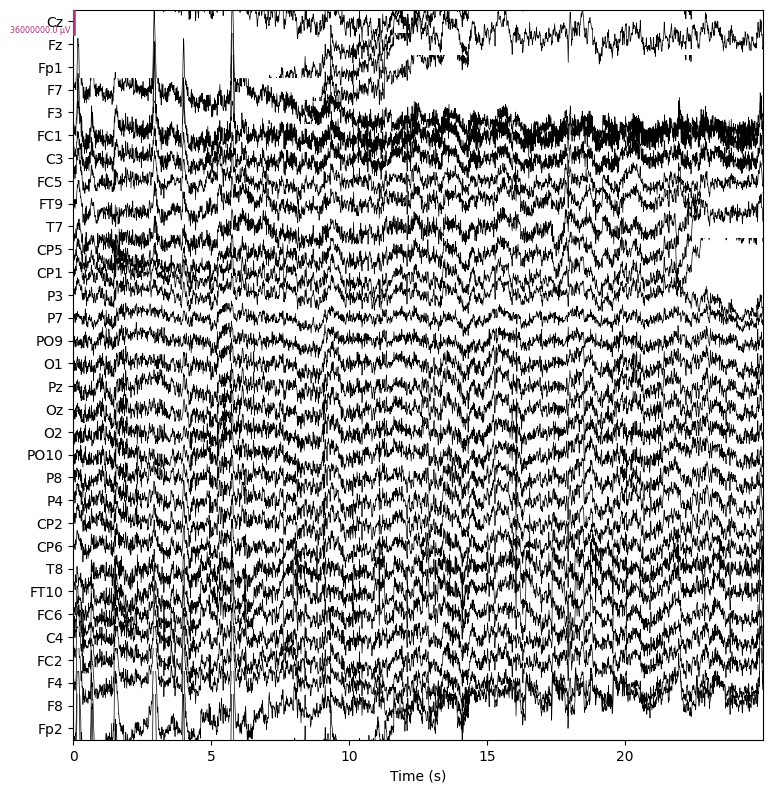

In [60]:
test.plot('raw')

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components


C:\Users\91798\AppData\Local\Temp\ipykernel_17872\2832289028.py:101: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  self.ica.fit(self.filt_arr)


Fitting ICA took 7.5s.
Creating RawArray with float64 data, n_channels=15, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


C:\Users\91798\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


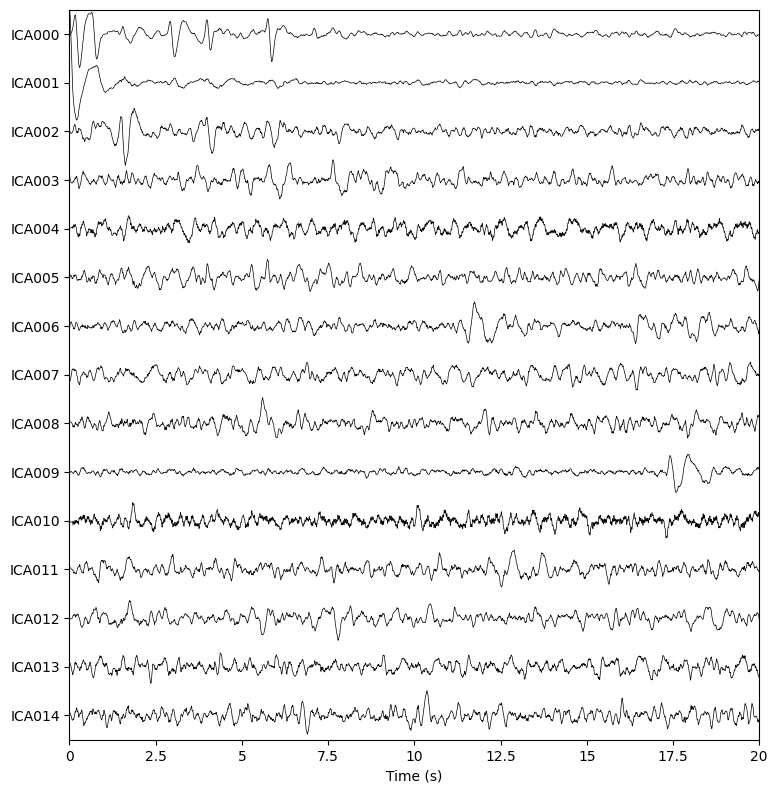

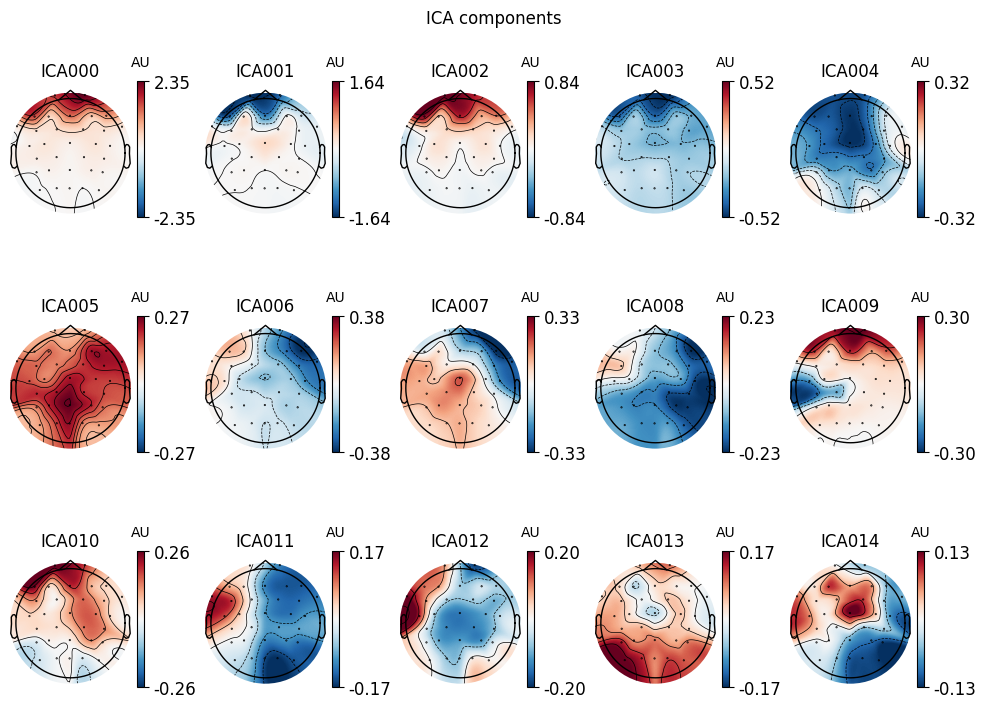

In [61]:
test.init_ICA()
test.plot_sources()

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 32 PCA components


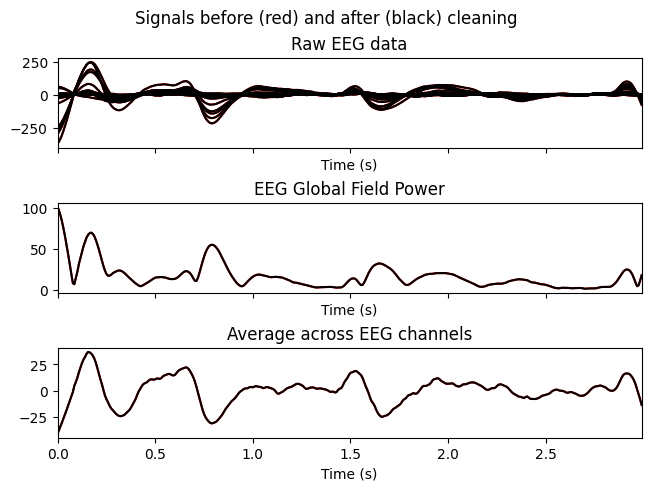

In [63]:
test.test_exclude([])

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated


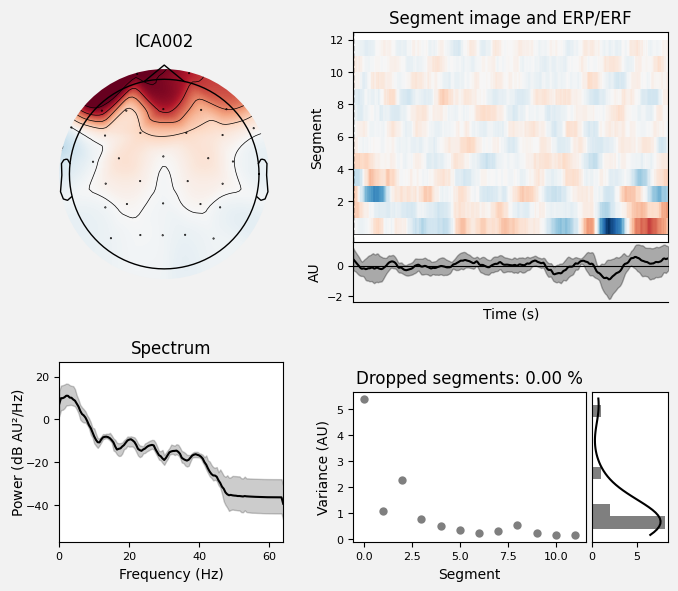

In [64]:
test.plot_properties([2])

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 32 PCA components


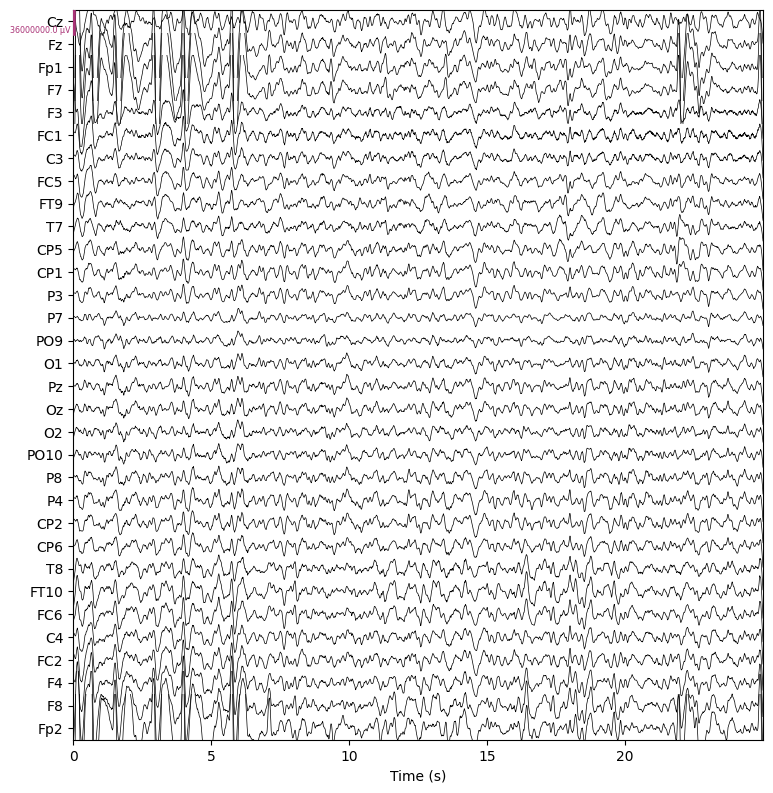

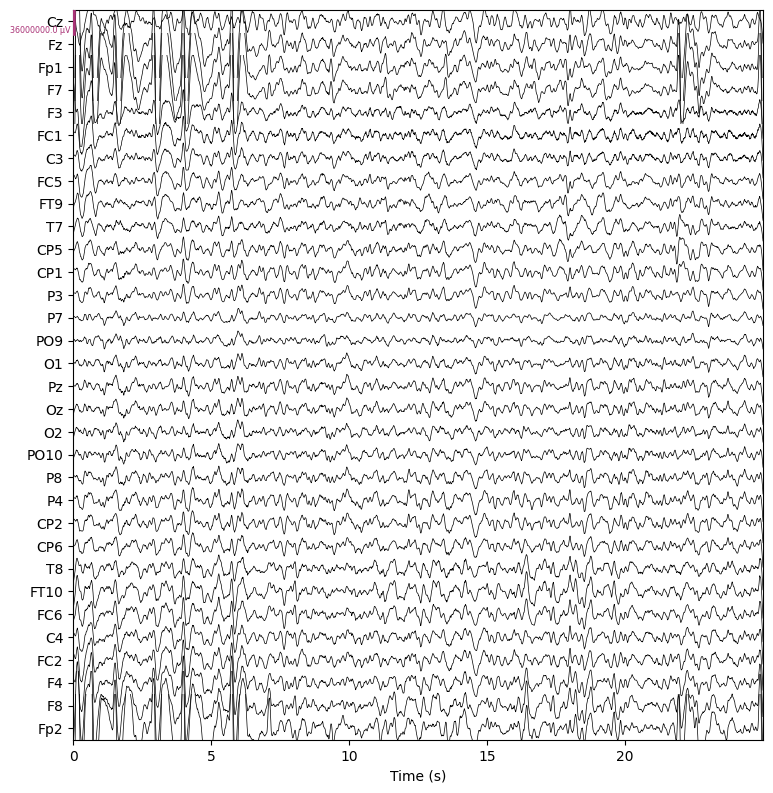

In [67]:
test.exclude_ICA([0,1,2,4,6,9,10,14])
test.plot('filtered')
test.plot('reconstructed')

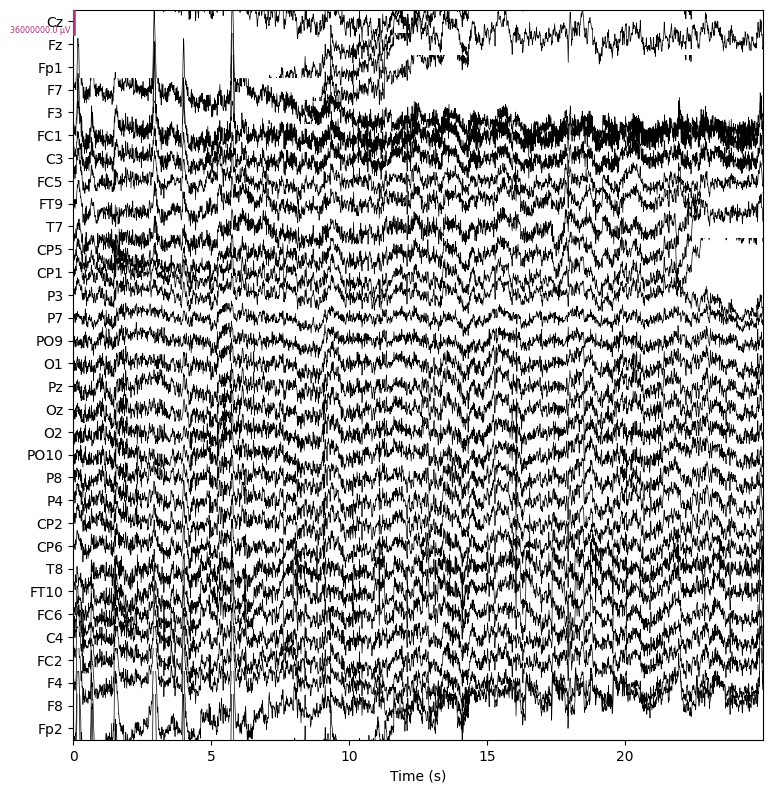

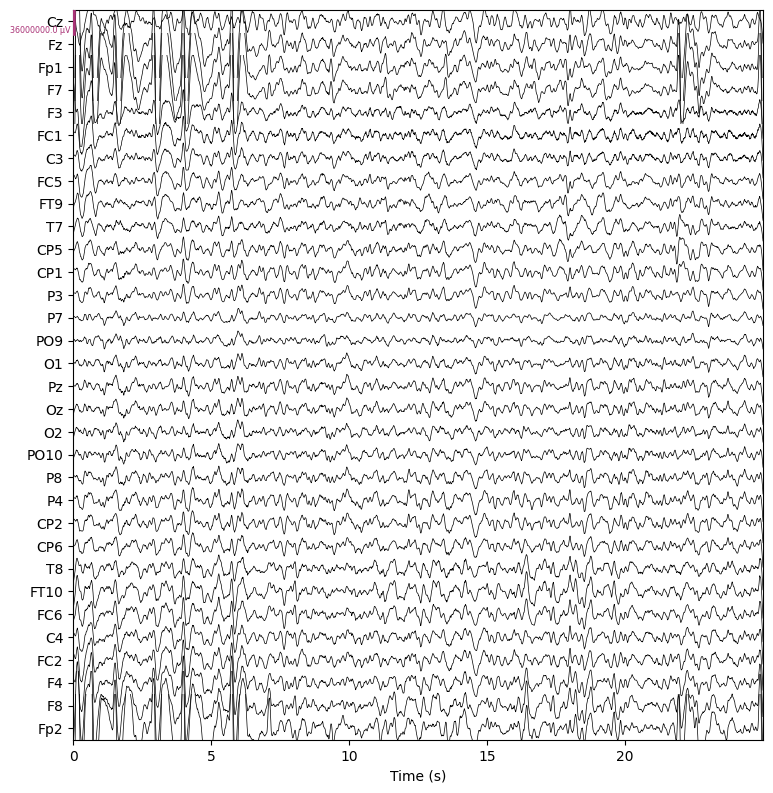

Creating RawArray with float64 data, n_channels=15, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


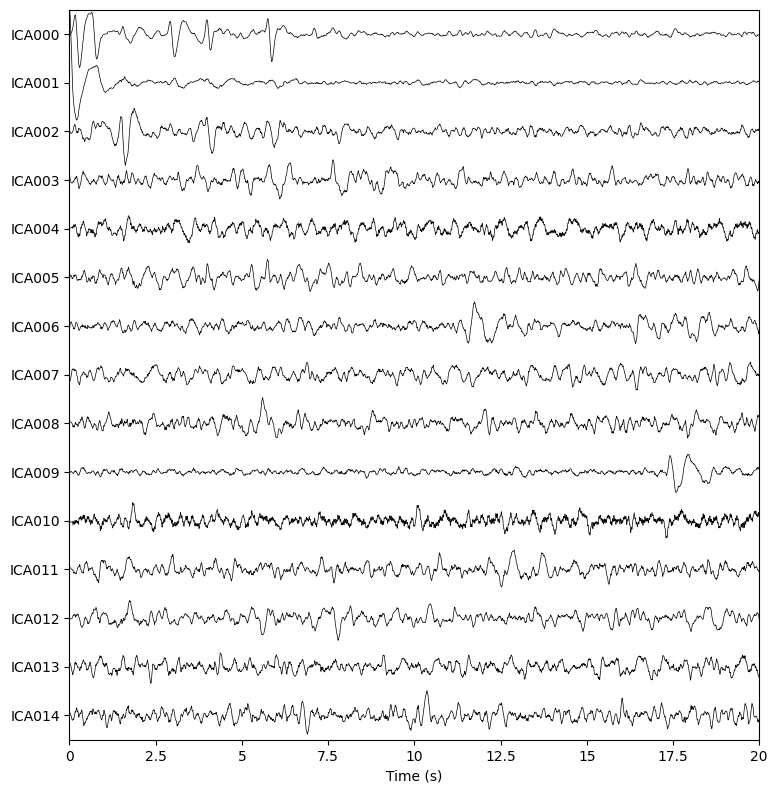

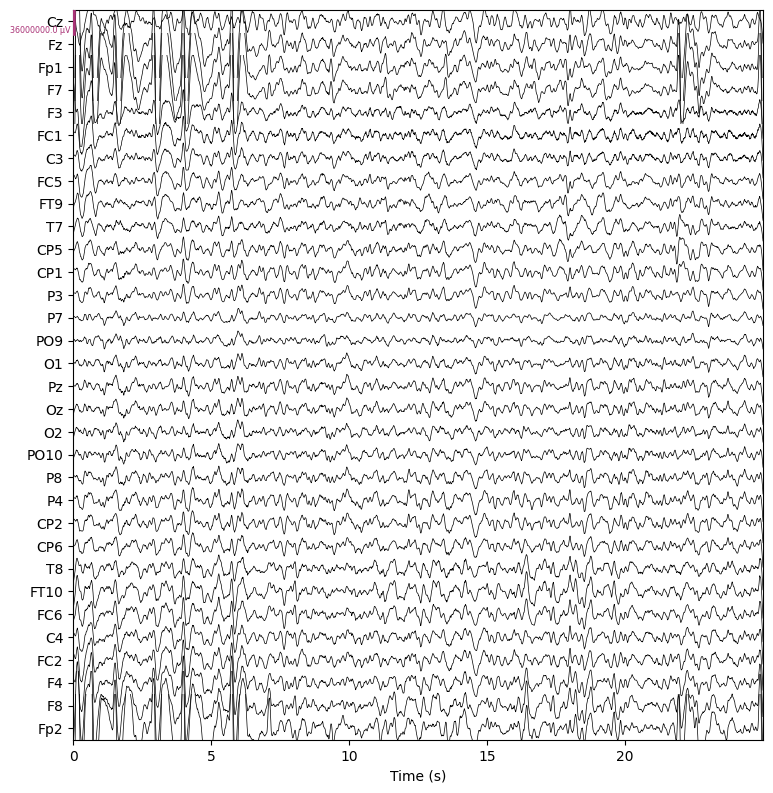

In [68]:
test.plot('raw', save=True)
test.plot('filtered', save=True)
test.plot('ica', save=True)
test.plot('reconstructed', save=True)

In [58]:
test.save_data()

### Doing this for Every Signal file

In [ ]:
data_types = ["Arithmetic", "Mirror_image", "Stroop"]
subs = list(range(1, 41))
for data_type in data_types:
    for sub_nr in subs:
        for trial_nr in range(1, 4):
            test = Recording(data_type, sub_nr, trial_nr)
            test.init_ICA()
            test.exclude_ICA([0,1,2,4,6,9,10,14])
            test.save_data()